**Set 300W dataset**

import module and packages

In [87]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

from xml.etree import ElementTree

from PIL import Image
import matplotlib.pyplot as plt

read xml format

In [88]:
# read file data from xml format of 300W
root_dir = '/data/komedi/backup/dataset/open_dataset/ibug_300W'
tree = ElementTree.parse(os.path.join(root_dir, f'labels_ibug_300W_{"train"}.xml'))
root = tree.getroot()
"""
6,666 number of file
"""

'\n6,666 number of file\n'

solve xml format

In [89]:
image_paths = []
landmarks = []
crops = []
for filename in root[2]:
    image_paths.append(os.path.join(root_dir, filename.attrib['file']))
    crops.append(filename[0].attrib)
    
    landmark = []
    for num in range(68):
        x_coordinate = int(filename[0][num].attrib['x'])
        y_coordinate = int(filename[0][num].attrib['y'])
        landmark.append([x_coordinate, y_coordinate])
    landmarks.append(landmark)
landmarks = np.array(landmarks).astype('float32')

get image name, path, crops, landmarks from xml

In [90]:
# set 68pt annot csv
margin = 200
plt.figure(figsize=(22,22))
csv_lists = []
start_num = 1000
max_num = start_num+500
os.makedirs(f"/data/komedi/300wdataset/{max_num}/images_{max_num}",exist_ok=True)
os.makedirs(f"/data/komedi/300wdataset/{max_num}/cropimg_{max_num}",exist_ok=True)
for _, num in enumerate(tqdm(range(start_num, len(image_paths)))):
    if num>=max_num:
        break
    csv_list = []

    image = Image.open(image_paths[num])
    # TODO crop dir 추가
    crop_image = image.crop((eval(crops[num]['left'])-margin//2,
                             eval(crops[num]['top'])-margin//2,
                             eval(crops[num]['left'])+eval(crops[num]['width'])+margin//2,
                             eval(crops[num]['top'])+eval(crops[num]['height'])+margin//2))
    
    image_name = Path(image_paths[num]).stem
    
    image.save(f"/data/komedi/300wdataset/{max_num}/images_{max_num}/{image_name}.jpg")
    crop_image.save(f"/data/komedi/300wdataset/{max_num}/cropimg_{max_num}/{image_name}.jpg")
    csv_list.append(f"{image_name}.jpg")
    csv_list.append(f"/data/komedi/300wdataset/{max_num}/images_{max_num}/{image_name}.jpg")
    csv_list.append(crops[num])

    for idx in range(len(landmarks[num])):
        csv_list.append((landmarks[num][idx][0],landmarks[num][idx][1]))

    csv_lists.append(csv_list)        
    
    df = pd.DataFrame(csv_lists, index=None)
    df.to_csv(f"{max_num}/300w_68pt_anno_{max_num}.csv",header=None, index=None)
print(f"{max_num}/300w_68pt_anno_{max_num}.csv is saved")

  9%|▉         | 500/5666 [01:17<13:15,  6.49it/s]

1500/300w_68pt_anno_1500.csv is saved


<Figure size 1584x1584 with 0 Axes>

load 68pt annotation csv file

In [91]:
max_num

1500

In [92]:
# df_lists = pd.read_csv(f"300w_68pt_anno_{max_num}.csv", header=None).values.tolist()
df_lists = pd.read_csv(f"{max_num}/300w_68pt_anno_{max_num}.csv", header=None).values.tolist()
"""
idx 0: file name
idx 1: file path
idx 2: bbox(left, top, width, height)
idx 3 ~ : landmark
"""
len(df_lists[0]) # 71 okay

71

set sorted list

In [93]:
# 18 point sort

IDX_LIST = {
    "1":27, # soft_tissue_nasion        -1
    "2":39, # right_inner_canthus     -2
    "3":42, # left_inner_canthus      -2
    "4":36, # right_outer_canthus     -3
    "5":45, # left_outer_canthus      -3
    "6":2, # right_zygomatic_width    -4
    "7":14, # left_zygomatic_width    -4
    "8":28, # mid_dorsum                -5
    "9":30, # nasal_tip                 -6
    "10":33, # subnasale                 -8
    "11":51, # philtral_tubercle        -10
    "12":48, # right_outer_commissure -11
    "13":54, # left_outer_commissure  -11
    "14":5, # right_gonial_width      -12
    "15":11, # left_gonial_width      -12
    "16":8, # mid_symphysis             -14
    "17":62, # lib_junction             -17
    "19":57
}

# 2 point to sort

def calculatelandmark(point1, point2):
    (x1,y1) = point1
    (x2,y2) = point2
    return (x1+x2)//2, (y1+y2)//2

def cal_list(kpt):
    cal_list = [
        calculatelandmark(kpt[3],kpt[2]), # mid_philtrum
        calculatelandmark(kpt[0],kpt[1]), # glabella
    ]
    return cal_list

sort 68pt to 20pt

In [94]:
# sort 68pt to 20pt
idx = 0
landmarks_list = []
for _, idx in enumerate(tqdm(range(len(df_lists)))):
    landmarks = []
    cal = []

    margin = 0
    bbox = (int(eval(df_lists[idx][2])['left'])-margin,
            int(eval(df_lists[idx][2])['top'])-margin,
            int(eval(df_lists[idx][2])['left'])+int(eval(df_lists[idx][2])['width'])+margin,
            int(eval(df_lists[idx][2])['top'])+int(eval(df_lists[idx][2])['height'])+margin
    )

    # image = Image.open(df_lists[idx][1])
    # crop_image = image.crop(bbox)

    # plt.figure(figsize=(22,22))
    # plt.imshow(crop_image)

    landmarks.append(df_lists[idx][0]) # append image name
    landmarks.append("W300")
    landmarks.append("S0")
    landmarks.append(df_lists[idx][1]) # append image path

    # bbox process
    box = []
    for i in range(len(bbox)):
        # if bbox[i]<=0:
        #     box.append(0)
        # else:
            landmarks.append(bbox[i])
    # landmarks.append(box) # append bbox value

    for idx, landmark in enumerate(df_lists[idx][3:]):
        if idx in list(IDX_LIST.values()):
            x,y = eval(landmark[1:-1])
            # plt.scatter(x-bbox[0], y-bbox[1])
            # plt.annotate(idx, (x-bbox[0], y-bbox[1]))
            landmarks.append((x,y)) # append auto landmarks
        if idx in (21,22,33,51):
            x,y = eval(landmark[1:-1])
            cal.append((x,y)) 
    landmarks.append(calculatelandmark(cal[0],cal[1])) # append calculate landmark
    landmarks.append(calculatelandmark(cal[2],cal[3])) # append calculate landmark
    
    landmarks_list.append(landmarks)
len(landmarks_list[0]) # 28 okay

100%|██████████| 500/500 [00:00<00:00, 3415.58it/s]


28

assemble 20pt and 7pt

In [95]:
max_num

1500

In [96]:
manual_anno = pd.read_csv(f"/data/komedi/300wdataset/{max_num}/300w_7pt_anno_{max_num}.csv").values.tolist()
sort_manual = []
for manual in manual_anno:
    if manual[3] == 7:
        sort_manual.append(manual)
len(sort_manual)//7

392

In [97]:
# assemble
assemble_list = []
for landmark in landmarks_list:
    for manual in sort_manual:
        if landmark[0]==manual[0]:
            x,y = eval(manual[5])["cx"], eval(manual[5])["cy"]
            landmark.append((x,y))
    assemble_list.append(landmark) # 35 x number of images
len(assemble_list[0]) # if 35, OK

28

In [101]:
len(assemble_list[0])

28

In [102]:
len(assemble_list)

500

sort not manual annotated file

In [103]:
# sort not manual annotate
finale_list = []
for assemble in assemble_list:
    if len(assemble)==35:
        finale_list.append(assemble)
len(finale_list)

395

save dataframe

In [104]:
max_num

1500

In [106]:
# dataframe and save
df = pd.DataFrame(finale_list)
df.to_csv(f"{max_num}/assemble_{max_num}.csv",header=None, index=None)

check

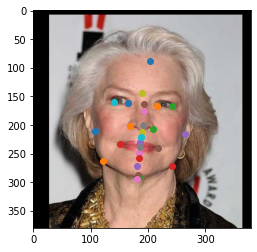

In [107]:
# check matching
image = Image.open(finale_list[0][3])
crop_image = image.crop((finale_list[0][4]-100,finale_list[0][5]-100,finale_list[0][6]+100,finale_list[0][7]+100))
for idx, landmark in enumerate(finale_list[0][8:]):
    x,y = landmark
    plt.scatter(x-(finale_list[0][4]-100),y-(finale_list[0][5]-100))
plt.imshow(crop_image)

In [108]:
# match from cropped image
crop_lists = []
for finale in finale_list:
    crop_list = []

    crop_list.append(finale[0])
    crop_list.append(finale[1])
    crop_list.append(finale[2])
    crop_list.append(finale[3])
    crop_list.append(finale[4])
    crop_list.append(finale[5])
    crop_list.append(finale[6])
    crop_list.append(finale[7])
    for landmark in finale[8:]:
        x,y = landmark
        x = x - (finale[4]-100)
        y = y - (finale[5]-100)
        crop_list.append((x,y))
    crop_lists.append(crop_list)

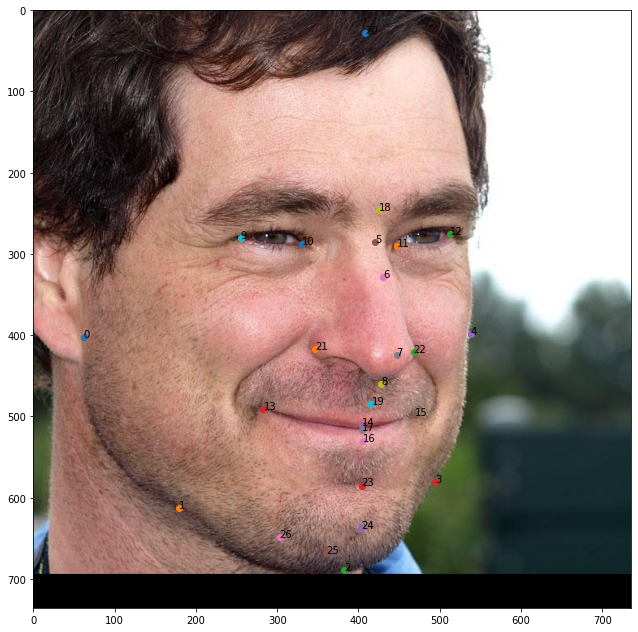

In [109]:
# check matching crop
plt.figure(figsize=(11,11))
image = Image.open(crop_list[3])
crop_image = image.crop((crop_list[4]-100,crop_list[5]-100,crop_list[6]+100,crop_list[7]+100))
for idx, landmark in enumerate(crop_list[8:]):
    x,y = landmark
    plt.scatter(x,y)
    plt.annotate(idx,(x,y))
plt.imshow(crop_image)

In [110]:
df = pd.DataFrame(crop_lists)
df.to_csv(f"{max_num}/crop_assemble_{max_num}.csv",header=None, index=None)
"""
여기서 landmark의 x,y는 crop image에 매칭된 값
"""